In [2]:
# Dependencies and Setup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from contextlib import redirect_stdout
import shap
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# Read in the speed dating data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
speeddate_df = pd.read_csv('speeddating.csv')
speeddate_df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',35.0,20.0,20.0,20.0,0.0,5.0,b'[21-100]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,8.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',6.0,9.0,7.0,7.0,6.0,5.0,b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.14,b'[0-0.33]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',60.0,0.0,0.0,40.0,0.0,0.0,b'[21-100]',b'[0-15]',b'[0-15]',b'[21-100]',b'[0-15]',b'[0-15]',7.0,8.0,10.0,7.0,7.0,5.0,b'[6-8]',b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[0-5]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',7.0,8.0,7.0,8.0,5.0,6.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',b'[6-8]',9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.54,b'[0.33-1]',3.0,2.0,4.0,b'[0-4]',b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',2.0,4.0,b'[2-5]',b'[2-5]',b'Law',19.0,18.0,19.0,18.0,14.0,12.0,b'[16-20]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',10.0,10.0,10.0,10.0,10.0,10.0,b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',b'[9-10]',15.0,20.0,20.0,15.0,15.0,15.0,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0,8.0,8.0,8.0,7.0,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',

In [4]:
# Drop unnecessary columns
speeddate_df.drop(columns=['has_null', 'decision', 'decision_o'], inplace=True)

for col in speeddate_df.columns[6:]:
    if 'd_' in col[0:2]:
        speeddate_df.drop(columns=col, inplace=True)

speeddate_df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'Law',35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,b'0'
1,1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'Law',60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,b'0'
2,1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',2.0,4.0,b'Law',19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,8.0,9.0,8.0,5.0,7.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.16,3.0,2.0,4.0,7.0,NaN,1.0,b'1'
3,1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',2.0,4.0,b'Law',30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,b'1'
4,1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',2.0,4.0,b'Law',30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,b'1'


In [5]:
# Clean data by removing unnecessary additions to the data
for col in speeddate_df:
    if speeddate_df[col].dtype == 'object':
        speeddate_df[col] = speeddate_df[col].map(lambda str: str.removeprefix("b'").removesuffix("'"))

speeddate_df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,Law,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,0
1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,Law,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,0
2,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,Law,19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,8.0,9.0,8.0,5.0,7.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.16,3.0,2.0,4.0,7.0,NaN,1.0,1
3,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,Law,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,1
4,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,Law,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,1


In [6]:
# Define a function to change the gender values to binaries and apply it to the column
def gender_to_bin(gender):
    if gender == "male":
        return 0
    else: 
        return 1

speeddate_df['gender'] = speeddate_df['gender'].apply(gender_to_bin)
speeddate_df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,1.0,1,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,Law,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,0
1,1.0,1,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,Law,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,0
2,1.0,1,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,2.0,4.0,Law,19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,8.0,9.0,8.0,5.0,7.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.16,3.0,2.0,4.0,7.0,NaN,1.0,1
3,1.0,1,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,2.0,4.0,Law,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,1
4,1.0,1,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,2.0,4.0,Law,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,1


In [7]:
# Change the data type for the numeric columns to float64
speeddate_df[['gender', 'samerace', 'match']] = speeddate_df[['gender', 'samerace', 'match']].astype('float64')
speeddate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 66 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   wave                           8378 non-null   float64
 1   gender                         8378 non-null   float64
 2   age                            8283 non-null   float64
 3   age_o                          8274 non-null   float64
 4   d_age                          8378 non-null   float64
 5   d_d_age                        8378 non-null   object 
 6   race                           8378 non-null   object 
 7   race_o                         8378 non-null   object 
 8   samerace                       8378 non-null   float64
 9   importance_same_race           8299 non-null   float64
 10  importance_same_religion       8299 non-null   float64
 11  field                          8378 non-null   object 
 12  pref_o_attractive              8289 non-null   f

In [8]:
# Convert categorical data to numeric with `pd.get_dummies`
categorical_cols = [col for col in speeddate_df if speeddate_df[col].dtype == 'object']
for col in categorical_cols:
    speeddate_df = pd.concat([speeddate_df, pd.get_dummies(speeddate_df[col])], axis=1)
    speeddate_df.drop(columns=col, inplace=True)

speeddate_df.head()

,wave,gender,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match,[0-1],[2-3],[4-6],[7-37],?,Asian/Pacific Islander/Asian-American,Black/African American,European/Caucasian-American,Latino/Hispanic American,Other,?,Asian/Pacific Islander/Asian-American,Black/African American,European/Caucasian-American,Latino/Hispanic American,Other,?,Acting,African-American Studies/History,American Studies,American Studies [Masters],Anthropology,Anthropology/Education,Applied Maths/Econs,Applied Physiology & Nutrition,Architecture,Art Education,Art History,Art History/medicine,Arts Administration,BUSINESS CONSULTING,Bilingual Education,Biochemistry,Biochemistry & Molecular Biophysics,Biology,Biology PhD,Biomedical Engineering,Biomedical Informatics,Biomedical engineering,Biotechnology,Business,Business & International Affairs,Business Administration,Business School,Business [Finance & Marketing],Business [MBA],Business and International Affairs [MBA/MIA Dual Degree],Business- MBA,Business/ Finance/ Real Estate,Business/Law,Business; Media,Business; marketing,Cell Biology,Chemistry,Classics,Climate Dynamics,Climate-Earth and Environ. Science,Clinical Psychology,Cognitive Studies in Education,Communications,Communications in Education,Comparative Literature,Computational Biochemsistry,Computer Science,Conservation biology,Consulting,Counseling Psychology,Creative Writing,Creative Writing - Nonfiction,Creative Writing [Nonfiction],Curriculum and Teaching/Giftedness,EDUCATION,ELECTRICAL ENGINEERING,Early Childhood Education,Earth and Environmental Science,Ecology,Economics,Economics and Political Science,Economics; English,Economics; Sociology,Ed.D. in higher education policy at TC,Education,Education Administration,Education Leadership - Public School Administration,Education Policy,Education- Literacy Specialist,Educational Psychology,Electrical Engg.,Electrical Engineering,Elementary Education,Elementary Education - Preservice,Elementary/Childhood Education [MA],Engineering,English,English Education,English and Comp Lit,Environmental Engineering,Epidemiology,Film,Finanace,Finance,Finance&Economics,Finance/Economics,Financial Engineering,Fundraising Management,GS Postbacc PreMed,GSAS,General management/finance,Genetics,Genetics & Development,German Literature,Health policy,Higher Ed. - M.A.,History,History [GSAS - PhD],History of Religion,Human Rights,Human Rights: Middle East,Industrial Engineering,Industrial Engineering/Operations Research,Instructional Media and Technology,Instructional Tech & Media,Intellectual Property Law,International Affairs,International Affairs - Economic Policy,International Affairs and Public Health,International Affairs/Business,International Affairs/Finance,International Business,International Development,International Educational Development,International Finance; Economic Policy,International Politics,International Relations,International Security Policy - SIPA,International affairs,Intrernational Affairs,Japanese Literature,Journalism,LAW,Law,Law and English Literature [J.D./Ph.D.],Law and Social Work,Law/Business,MA Biotechnology,MA Science Education,MA Teaching Social Studies,MA in Quantitative Methods,MBA,MBA - Private Equity / Real Estate,MBA / Master of International Affairs [SIPA

In [9]:
# Drop rows with missing values
speeddate_df.dropna(axis=0, how='any', inplace=True)
speeddate_df.head()

,wave,gender,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match,[0-1],[2-3],[4-6],[7-37],?,Asian/Pacific Islander/Asian-American,Black/African American,European/Caucasian-American,Latino/Hispanic American,Other,?,Asian/Pacific Islander/Asian-American,Black/African American,European/Caucasian-American,Latino/Hispanic American,Other,?,Acting,African-American Studies/History,American Studies,American Studies [Masters],Anthropology,Anthropology/Education,Applied Maths/Econs,Applied Physiology & Nutrition,Architecture,Art Education,Art History,Art History/medicine,Arts Administration,BUSINESS CONSULTING,Bilingual Education,Biochemistry,Biochemistry & Molecular Biophysics,Biology,Biology PhD,Biomedical Engineering,Biomedical Informatics,Biomedical engineering,Biotechnology,Business,Business & International Affairs,Business Administration,Business School,Business [Finance & Marketing],Business [MBA],Business and International Affairs [MBA/MIA Dual Degree],Business- MBA,Business/ Finance/ Real Estate,Business/Law,Business; Media,Business; marketing,Cell Biology,Chemistry,Classics,Climate Dynamics,Climate-Earth and Environ. Science,Clinical Psychology,Cognitive Studies in Education,Communications,Communications in Education,Comparative Literature,Computational Biochemsistry,Computer Science,Conservation biology,Consulting,Counseling Psychology,Creative Writing,Creative Writing - Nonfiction,Creative Writing [Nonfiction],Curriculum and Teaching/Giftedness,EDUCATION,ELECTRICAL ENGINEERING,Early Childhood Education,Earth and Environmental Science,Ecology,Economics,Economics and Political Science,Economics; English,Economics; Sociology,Ed.D. in higher education policy at TC,Education,Education Administration,Education Leadership - Public School Administration,Education Policy,Education- Literacy Specialist,Educational Psychology,Electrical Engg.,Electrical Engineering,Elementary Education,Elementary Education - Preservice,Elementary/Childhood Education [MA],Engineering,English,English Education,English and Comp Lit,Environmental Engineering,Epidemiology,Film,Finanace,Finance,Finance&Economics,Finance/Economics,Financial Engineering,Fundraising Management,GS Postbacc PreMed,GSAS,General management/finance,Genetics,Genetics & Development,German Literature,Health policy,Higher Ed. - M.A.,History,History [GSAS - PhD],History of Religion,Human Rights,Human Rights: Middle East,Industrial Engineering,Industrial Engineering/Operations Research,Instructional Media and Technology,Instructional Tech & Media,Intellectual Property Law,International Affairs,International Affairs - Economic Policy,International Affairs and Public Health,International Affairs/Business,International Affairs/Finance,International Business,International Development,International Educational Development,International Finance; Economic Policy,International Politics,International Relations,International Security Policy - SIPA,International affairs,Intrernational Affairs,Japanese Literature,Journalism,LAW,Law,Law and English Literature [J.D./Ph.D.],Law and Social Work,Law/Business,MA Biotechnology,MA Science Education,MA Teaching Social Studies,MA in Quantitative Methods,MBA,MBA - Private Equity / Real Estate,MBA / Master of International Affairs [SIPA

In [10]:
# Set a random state to be applied to all the models
random_state = 72

# Assign target variable and features
y = speeddate_df['match']
X = speeddate_df.drop(columns='match')

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model

In [11]:
# Declare a logistic regression model
logistic_regression_model = LogisticRegression(random_state=random_state)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)
# Generate predictions
lr_predictions = logistic_regression_model.predict(X_test_scaled)

# Create and save the confusion matrix for predictions
lr_matrix = confusion_matrix(y_test, lr_predictions)

# Print the confusion matrix for the predictions
lr_cm_df = pd.DataFrame(
    lr_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
lr_acc_score = accuracy_score(y_test, lr_predictions)
# Displaying results
print("Confusion Matrix")
display(lr_cm_df)
print(f"Accuracy Score : {lr_acc_score}")
print("Classification Report")
print(classification_report(y_test, lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,199,16
Actual 1,23,24


Accuracy Score : 0.851145038167939
Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       215
         1.0       0.60      0.51      0.55        47

    accuracy                           0.85       262
   macro avg       0.75      0.72      0.73       262
weighted avg       0.84      0.85      0.85       262



# Random Forest Model

In [12]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=random_state)

In [13]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [14]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [15]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [16]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,209,6
Actual 1,35,12


Accuracy Score : 0.8435114503816794
Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       215
         1.0       0.67      0.26      0.37        47

    accuracy                           0.84       262
   macro avg       0.76      0.61      0.64       262
weighted avg       0.82      0.84      0.81       262



In [17]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.04009673037116216, 'like'),
 (0.03961835814598177, 'guess_prob_liked'),
 (0.038348021234444245, 'shared_interests_o'),
 (0.037478345760403244, 'attractive_partner'),
 (0.03358192967796849, 'funny_o'),
 (0.03339462315674962, 'attractive_o'),
 (0.030740007915958992, 'shared_interests_partner'),
 (0.026236465147481725, 'interests_correlate'),
 (0.025347538221109092, 'funny_partner'),
 (0.021468996379731244, 'ambitous_o'),
 (0.021388468788658986, 'pref_o_shared_interests'),
 (0.01967691895884176, 'pref_o_sincere'),
 (0.01945816709600294, 'pref_o_funny'),
 (0.019059363074792536, 'age_o'),
 (0.018436334209953262, 'sinsere_o'),
 (0.018211847240756404, 'pref_o_attractive'),
 (0.017345746847293245, 'exercise'),
 (0.01707227918235351, 'intelligence_o'),
 (0.016226929223322417, 'pref_o_intelligence'),
 (0.01616675672170765, 'd_age'),
 (0.015817901308367573, 'ambition_partner'),
 (0.015572280758820079, 'pref_o_ambitious'),
 (0.014960109590496474, 'expected_num_matches'),
 (0.014734132500036376

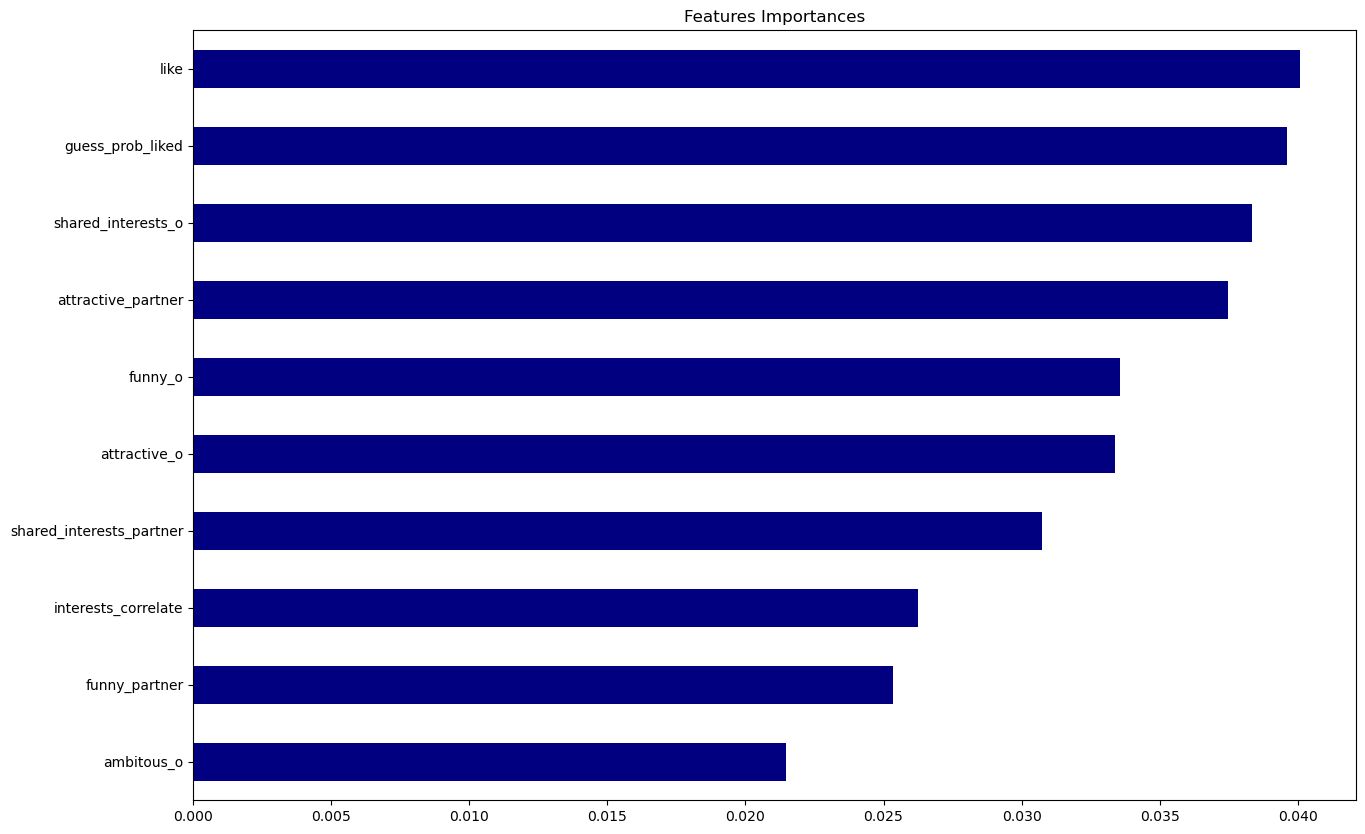

In [21]:
# Visualize the features by importance and save the graph as a PNG file
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances').tail(10)
importances_plot = importances_sorted.plot(kind='barh', color='navy', ylabel='', title= 'Features Importances', legend=False, figsize=(15,10))
importances_plot.get_figure().savefig('graphs/feature_importances_top10.png')

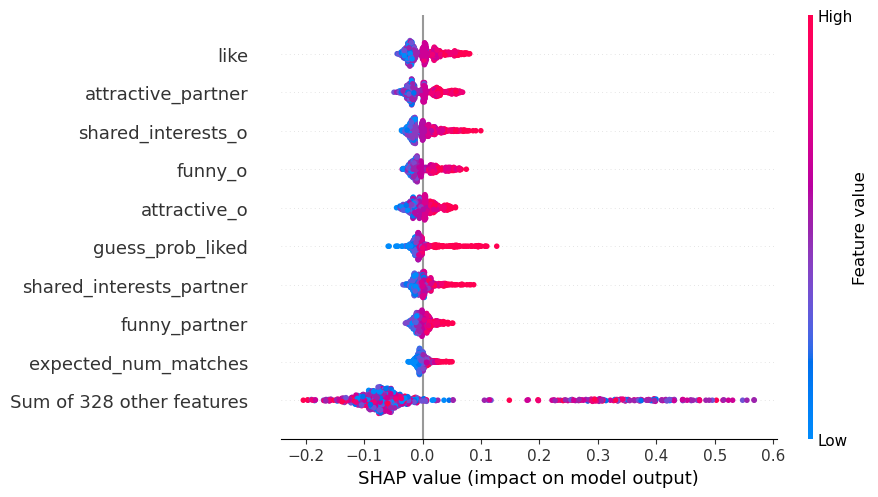

In [26]:
# Graph the SHAP values of the model with the explainer
explainer = shap.Explainer(rf_model, feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values[:,:,1])

# Deep Learning Model

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu', 'leaky_relu', 'gelu'])
    activation_last = hp.Choice('activation_last',['sigmoid', 'tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=500,
        step=5), 
        activation=activation, 
        input_dim=len(X_train.columns),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 20)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=500,
            step=5),
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_last))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [ ]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=30,
    hyperband_iterations=2,
    directory=os.path.normpath('C:/Users/Hansle Goh/Desktop/speed-dating-prediction-project/'),
    project_name='speed_dating_keras_tuner',
    overwrite=True)

In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled,y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)])

Trial 180 Complete [00h 00m 09s]
val_accuracy: 0.8740457892417908

Best val_accuracy So Far: 0.8816794157028198
Total elapsed time: 00h 15m 35s


In [ ]:
# Get top 10 model hyperparameters and print the values
from pprint import pprint
top_hps = tuner.get_best_hyperparameters(10)
for param in top_hps:
    pprint(param.values)
    print('-'*40)

{'activation': 'relu',
 'activation_last': 'sigmoid',
 'first_units': 221,
 'num_layers': 15,
 'tuner/bracket': 0,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_0': 271,
 'units_1': 106,
 'units_10': 166,
 'units_11': 81,
 'units_12': 491,
 'units_13': 261,
 'units_14': 21,
 'units_15': 426,
 'units_16': 436,
 'units_17': 326,
 'units_18': 206,
 'units_19': 246,
 'units_2': 356,
 'units_3': 121,
 'units_4': 11,
 'units_5': 136,
 'units_6': 71,
 'units_7': 211,
 'units_8': 11,
 'units_9': 31}
----------------------------------------
{'activation': 'relu',
 'activation_last': 'sigmoid',
 'first_units': 66,
 'num_layers': 1,
 'tuner/bracket': 3,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/round': 3,
 'tuner/trial_id': '0136',
 'units_0': 161,
 'units_1': 221,
 'units_10': 66,
 'units_11': 401,
 'units_12': 131,
 'units_13': 296,
 'units_14': 371,
 'units_15': 156,
 'units_16': 181,
 'units_17': 151,
 'units_18': 26,
 'units_19': 166,
 'units_2': 1

In [ ]:
# Evaluate the top 3 models against the test dataset
top_models = tuner.get_best_models(3)
for model in top_models:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    print('-'*80)

9/9 - 0s - loss: 0.8737 - accuracy: 0.8817 - 486ms/epoch - 54ms/step
Loss: 0.8737086653709412, Accuracy: 0.8816794157028198
--------------------------------------------------------------------------------
9/9 - 0s - loss: 0.6660 - accuracy: 0.8817 - 216ms/epoch - 24ms/step
Loss: 0.6659648418426514, Accuracy: 0.8816794157028198
--------------------------------------------------------------------------------
9/9 - 0s - loss: 0.6876 - accuracy: 0.8817 - 339ms/epoch - 38ms/step
Loss: 0.6876357197761536, Accuracy: 0.8816794157028198
--------------------------------------------------------------------------------


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 221)               74698     
                                                                 
 dense_1 (Dense)             (None, 271)               60162     
                                                                 
 dense_2 (Dense)             (None, 106)               28832     
                                                                 
 dense_3 (Dense)             (None, 356)               38092     
                                                                 
 dense_4 (Dense)             (None, 121)               43197     
                                                                 
 dense_5 (Dense)             (None, 11)                1342      
                                                                 
 dense_6 (Dense)             (None, 136)               1

In [ ]:
#Predict
best_hps=tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train_scaled, y_train, epochs=100)

val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
25/25 [==============================] - 3s 6ms/step - loss: 2.0486 - accuracy: 0.8053
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 1.2390 - accuracy: 0.8232
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.8403 - accuracy: 0.8232
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6340 - accuracy: 0.8270
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5334 - accuracy: 0.8817
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4882 - accuracy: 0.8919
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4084 - accuracy: 0.9173
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3761 - accuracy: 0.9300
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3357 - accuracy: 0.9351
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3026 - accuracy: 0.9415
Epoch 11/

In [ ]:
# Fit the model again with the best epoch and evaluate the model using the test data
hypermodel.fit(X_train_scaled, y_train, epochs=best_epoch)
model_loss, model_accuracy = hypermodel.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0662 - accuracy: 0.9962
Epoch 2/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0658 - accuracy: 0.9962
Epoch 3/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0653 - accuracy: 0.9962
Epoch 4/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0647 - accuracy: 0.9962
Epoch 5/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0644 - accuracy: 0.9962
Epoch 6/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0638 - accuracy: 0.9962
Epoch 7/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0643 - accuracy: 0.9962
Epoch 8/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0630 - accuracy: 0.9962
Epoch 9/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0625 - accuracy: 0.9962
Epoch 10/75
25/25 [==============================] - 0s 5ms/step - loss: 0.0620 - accuracy: 0.9962
Epoch 11/75
25/25 [